Sharpe Ratio Portfolio:
Weights: [ 0.15202905 -0.13302031  0.98099126]
Return: 0.18205895795996557
Volatility: 0.3910053157050045
Expected Shortfall: 0.7543764920342733
Sharpe Ratio: 0.34413587886228153
RR_p: 0.1783710910676843

RR_p Portfolio:
Weights: [0.33005597 0.04734918 0.62259485]
Return: 0.16038809491089467
Volatility: 0.4177708618780454
Expected Shortfall: 0.38318818125453746
Sharpe Ratio: 0.2702153386270598
RR_p: 0.29460223575086564


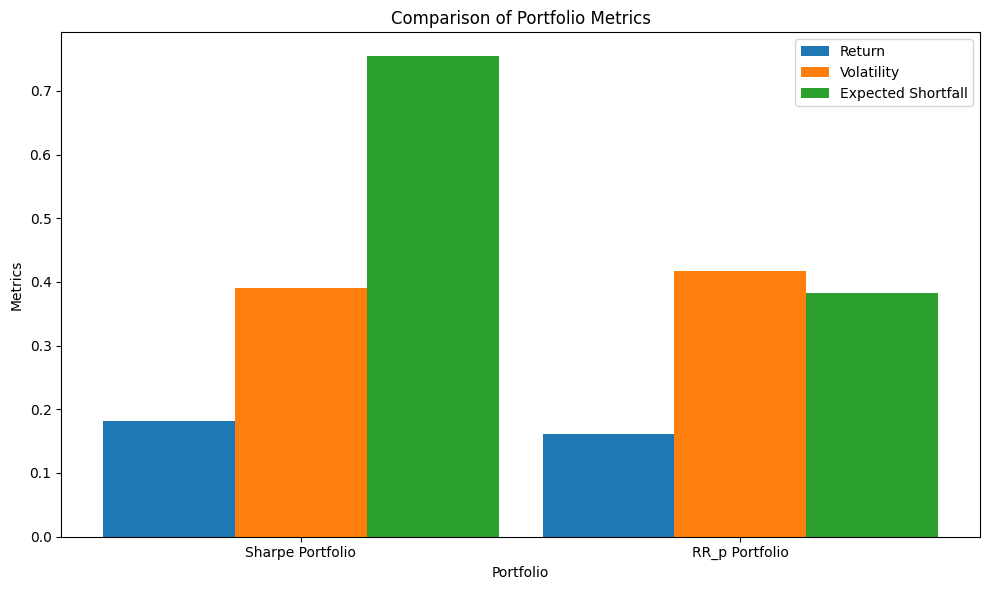

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')
returns = data.values  # Assuming the data contains only returns

returns = data.values
risk_free_rate = 0.0475
alpha = 0.025

# Calculate portfolio statistics
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def expected_shortfall(returns, weights, alpha):
    portfolio_returns = np.dot(returns, weights)
    sorted_returns = np.sort(portfolio_returns)
    cutoff_index = int(np.ceil(alpha * len(sorted_returns)))
    return -np.mean(sorted_returns[:cutoff_index])  # Negative because ES measures loss

# Sharpe Ratio Objective
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    port_return = portfolio_return(weights, mean_returns)
    port_volatility = portfolio_volatility(weights, cov_matrix)
    return -(port_return - risk_free_rate) / port_volatility  # Negative for maximization

# Risk-adjusted Return (RR_p) Objective
def risk_adjusted_return(weights, mean_returns, returns, risk_free_rate, alpha):
    port_return = portfolio_return(weights, mean_returns)
    es = expected_shortfall(returns, weights, alpha)
    return -(port_return - risk_free_rate) / es  # Negative for maximization

# Constraints and bounds
num_assets = returns.shape[1]
mean_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns, rowvar=False)
bounds = [(-1, 1) for _ in range(num_assets)]  # Short allowed but no weight < -1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights = 1

# Optimization for Sharpe Ratio Portfolio
result_sharpe = minimize(sharpe_ratio, num_assets * [1. / num_assets], args=(mean_returns, cov_matrix, risk_free_rate),
                         method='SLSQP', bounds=bounds, constraints=constraints)
weights_sharpe = result_sharpe.x

# Optimization for RR_p Portfolio
result_rrp = minimize(risk_adjusted_return, num_assets * [1. / num_assets],
                      args=(mean_returns, returns, risk_free_rate, alpha),
                      method='SLSQP', bounds=bounds, constraints=constraints)
weights_rrp = result_rrp.x

# Calculate portfolio statistics for both portfolios
def calculate_portfolio_stats(weights):
    port_return = portfolio_return(weights, mean_returns)
    port_volatility = portfolio_volatility(weights, cov_matrix)
    port_es = expected_shortfall(returns, weights, alpha)
    sharpe = (port_return - risk_free_rate) / port_volatility
    rr_p = (port_return - risk_free_rate) / port_es
    return port_return, port_volatility, port_es, sharpe, rr_p

stats_sharpe = calculate_portfolio_stats(weights_sharpe)
stats_rrp = calculate_portfolio_stats(weights_rrp)

# Print results
print("Sharpe Ratio Portfolio:")
print("Weights:", weights_sharpe)
print("Return:", stats_sharpe[0])
print("Volatility:", stats_sharpe[1])
print("Expected Shortfall:", stats_sharpe[2])
print("Sharpe Ratio:", stats_sharpe[3])
print("RR_p:", stats_sharpe[4])

print("\nRR_p Portfolio:")
print("Weights:", weights_rrp)
print("Return:", stats_rrp[0])
print("Volatility:", stats_rrp[1])
print("Expected Shortfall:", stats_rrp[2])
print("Sharpe Ratio:", stats_rrp[3])
print("RR_p:", stats_rrp[4])

# Visualization
labels = ['Sharpe Portfolio', 'RR_p Portfolio']
returns_plot = [stats_sharpe[0], stats_rrp[0]]
volatility_plot = [stats_sharpe[1], stats_rrp[1]]
es_plot = [stats_sharpe[2], stats_rrp[2]]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, returns_plot, width, label='Return')
ax.bar(x, volatility_plot, width, label='Volatility')
ax.bar(x + width, es_plot, width, label='Expected Shortfall')

ax.set_xlabel('Portfolio')
ax.set_ylabel('Metrics')
ax.set_title('Comparison of Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()
